In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import h5py
from skimage import io
from skimage.segmentation import mark_boundaries, slic
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn.preprocessing as preprocessing
from pysptools import spectro, noise
from tqdm import tqdm

find_index = lambda x, wvls: np.argmin(np.abs(wvls - x), axis = 0)

def manual_features(dataset, list_of_wavelengths, wavelengths, sigma = None):
    features = np.array([dataset[:, :, find_index(wl, wavelengths)] for wl in list_of_wavelengths])
    if sigma is not None:
        features = np.array([gaussian_filter(f, sigma = sigma) for f in features])
    return features

def upsample_to_slic(downsampled, slic_pattern):
    x_size, y_size, spectral_size = slic_pattern.shape[0], slic_pattern.shape[1], downsampled.shape[-1]
    upsampled = np.zeros((x_size*y_size, spectral_size))
    downsampled = downsampled.reshape(x_size*y_size, spectral_size)

    slic_pattern = slic_pattern.flatten()
    for i in tqdm(range(0, len(np.unique(slic_pattern)))):
        region_i = np.where(slic_pattern == (i+1))[0]
        upsampled[region_i, :] = np.median(downsampled[region_i, :], axis = 0)
        # specs, counts = np.unique(downsampled[region_i], return_counts = True, axis = 0)
        # if np.all(counts == counts[0]):
        #     upsampled[region_i, :] = np.mean(specs, axis = 0)
        # else:
        #     upsampled[region_i, :] = specs[np.argmax(counts)]
    return upsampled.reshape(x_size, y_size, spectral_size)

def plot_kmeans_inertia(X, cluster_range):
    inertias = []

    for k in cluster_range:
        kmeans = KMeans(n_clusters = k, random_state = 10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    fig, ax = plt.subplots(figsize = (5, 4))
    ax.plot(cluster_range, inertias, marker = 'o')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_title('K-Means Inertia for Different Cluster Counts', fontsize = 18)
    ax.set_xlabel('Number of Clusters', fontsize = 14)
    ax.set_ylabel('Inertia', fontsize = 14)
    ax.set_xticks(cluster_range)
    ax.grid(True)
    fig.tight_layout()

def upscale_array(arr, target_shape):
    """
    Upscale a 3D array to a specified shape using numpy.kron.

    Parameters:
        arr (np.array): Input array to be upscaled.
        target_shape (tuple): Target shape of the upscaled array. It must be in the format (new_height, new_width, unchanged_depth).

    Returns:
        np.array: The upscaled array with the specified target shape.
    """

    upscale_factor_1 = target_shape[0] // arr.shape[0]
    upscale_factor_2 = target_shape[1] // arr.shape[1]

    if upscale_factor_1 * arr.shape[0] != target_shape[0] or upscale_factor_2 * arr.shape[1] != target_shape[1]:
        raise ValueError("The target dimensions are not multiples of the original dimensions.")

    kernel = np.ones((upscale_factor_1, upscale_factor_2))
    upscaled_array = np.array([np.kron(arr[:, :, i], kernel) for i in range(arr.shape[2])])
    upscaled_array = upscaled_array.transpose((1, 2, 0))

    return upscaled_array

# SLIC Multimodality

In this notebook we will attempt to improve the classification performance of a spectral imaging technique, in this case Reflectance NIR-SWIR spectroscopy, by combining it with another spectroscopy technique, in this case LIBS. For that, two datasets will be use:

1. HSI dataset of high resolution 
1.  Sparse LIBS dataset (something like 10x10)

The SLIC segmentation algorithm will be used on the hyperspectral imaging dataset to perform a sparse contour of the most relevant regions in the image. To each of the regions of the image, point(s) of the LIBS dataset are assigned, and upscaling is perform to fill this regions.

Finally we perform classification using Mid-level fusion, adjusting the weigth each tecchnique will have on the final classification.

# 1. Dataset Loading

In [2]:
fname = "E:/Data/Data_Collab/collab_SLIC.h5"

hf = h5py.File(fname, 'r')

libs_dset = np.array(hf.get("LIBS/Data"))
libs_wavelegths = np.array(hf.get("LIBS/Wavelengths"))

hsi_dset = np.array(hf.get("HSI/Data"))
hsi_wavelegths = np.array(hf.get("HSI/Wavelengths"))

hf.close()

In [3]:
x_size = hsi_dset.shape[0]
y_size = hsi_dset.shape[1]
spectral_size_hsi = hsi_dset.shape[2]
spectral_size_libs = libs_dset.shape[2]

In [4]:
end_band = -20
hsi_dset_pro = noise.SavitzkyGolay().denoise_bands(hsi_dset[:, :, :end_band], 5, 3) 
hsi_dset_pro = np.array(hsi_dset_pro)
index = np.where(hsi_dset_pro < 0.1) #had it at 0.05 but shadows were forming in clustering
hsi_dset_pro[index] = 0

signals = [np.ndarray.flatten(hsi_dset_pro[ii,jj,:]) for ii in range(0, x_size) for jj in range(0, y_size) ]

for xy in tqdm(range(0, len(signals))):  
    try:
        norm, x_hull, y_hull = spectro.convex_hull_removal(signals[xy], hsi_wavelegths)
    except: 
        norm = signals[xy]
    signals[xy] = norm

hsi_dset_pro = np.array(signals).reshape(x_size, y_size, (spectral_size_hsi + end_band))

100%|██████████| 7040/7040 [00:37<00:00, 188.57it/s]


## 1.1 Check Datasets

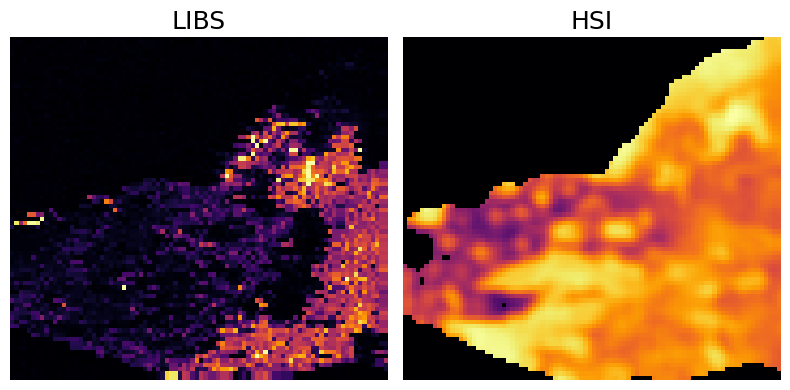

In [5]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))

ax = axs[0]
ax.imshow(libs_dset[:, :, find_index(610.22, libs_wavelegths)],
          cmap = 'inferno',
          interpolation = 'nearest')
ax.set_title("LIBS", fontsize = 18)
ax.axis("off")

ax = axs[1]
ax.imshow(hsi_dset_pro[:, :, find_index(1400, hsi_wavelegths)],
          cmap = 'inferno',
          interpolation = 'nearest')
ax.set_title("HSI", fontsize = 18)
ax.axis("off")

fig.tight_layout()

## 1.2 Downsample LIBS & HSI dataset

In [65]:
skip_pixel = 4
mid_point = skip_pixel//2
libs_dset_downsample = np.array(libs_dset[mid_point::skip_pixel, mid_point::skip_pixel])
hsi_dset_downsample = np.array(hsi_dset_pro[mid_point::skip_pixel, mid_point::skip_pixel])

target_shape = hsi_dset.shape[:2]
libs_dset_downsample = upscale_array(libs_dset_downsample, target_shape)
hsi_dset_downsample = upscale_array(hsi_dset_downsample, target_shape)

(-0.5, 87.5, 79.5, -0.5)

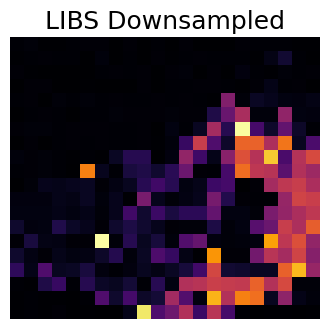

In [61]:
fig, axs = plt.subplots(1, 1, figsize = (4, 4))

ax = axs
ax.imshow(libs_dset_downsample[:, :, find_index(610.22, libs_wavelegths)],
          cmap = 'inferno',
          interpolation = 'nearest')
ax.set_title("LIBS Downsampled", fontsize = 18)
ax.axis("off")

### 1.2.1 Montage

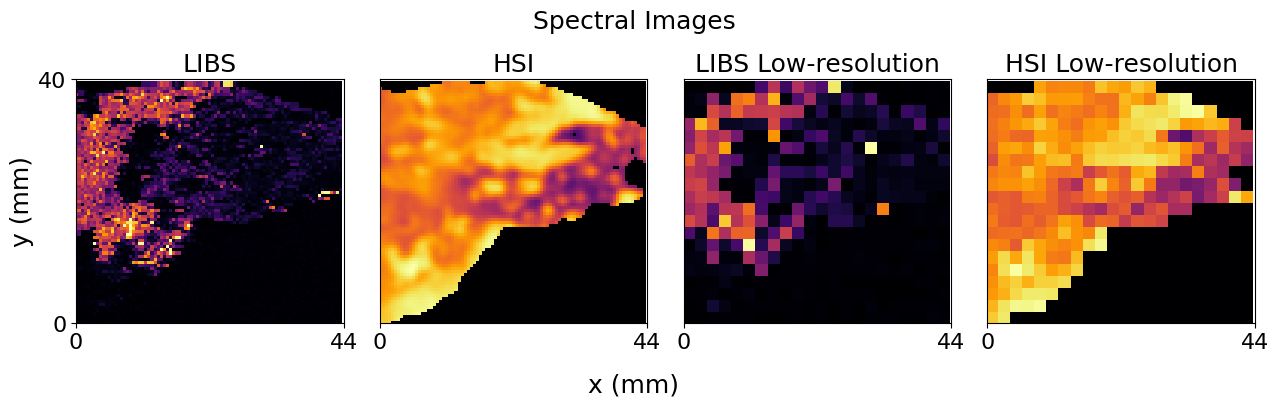

In [67]:
fig, axs = plt.subplots(1, 4, figsize = (13, 4))

fig.suptitle("Spectral Images", fontsize = 18)

ax = axs[0]
ax.imshow(libs_dset[:, :, find_index(610.22, libs_wavelegths)][::, ::-1],
          cmap = 'inferno',
          interpolation = 'nearest')
ax.set_title("LIBS", fontsize = 18)
ax.set_xticks([0, y_size])
ax.set_xticklabels([0, y_size//2], fontsize = 16)
ax.set_yticks([0, x_size])
ax.set_yticklabels([0, x_size//2], fontsize = 16)
ax.set_xlim(0, y_size)
ax.set_ylim(0, x_size)

ax = axs[1]
ax.imshow(hsi_dset_pro[:, :, find_index(1400, hsi_wavelegths)][::, ::-1],
          cmap = 'inferno',
          interpolation = 'nearest')
ax.set_title("HSI", fontsize = 18)
ax.set_xticks([0, y_size])
ax.set_xticklabels([0, y_size//2], fontsize = 16)
ax.set_yticks([ ])
ax.set_xlim(0, y_size)
ax.set_ylim(0, x_size)

ax = axs[2]
ax.imshow(libs_dset_downsample[:, :, find_index(610.22, libs_wavelegths)][::, ::-1],
          cmap = 'inferno',
          interpolation = 'nearest')
ax.set_title("LIBS Low-resolution", fontsize = 18)
ax.set_xticks([0, y_size])
ax.set_xticklabels([0, y_size//2], fontsize = 16)
ax.set_yticks([ ])
ax.set_xlim(0, y_size)
ax.set_ylim(0, x_size)

ax = axs[3]
ax.imshow(hsi_dset_downsample[:, :, find_index(1400, hsi_wavelegths)][::, ::-1],
          cmap = 'inferno',
          interpolation = 'nearest')
ax.set_title("HSI Low-resolution", fontsize = 18)
ax.set_xticks([0, y_size])
ax.set_xticklabels([0, y_size//2], fontsize = 16)
ax.set_yticks([ ])
ax.set_xlim(0, y_size)
ax.set_ylim(0, x_size)

fig.supxlabel("x (mm)", fontsize = 18)
fig.supylabel("y (mm)", fontsize = 18)
fig.tight_layout()

# fig.savefig("Images/spectral_maps_with_hsi.jpg", dpi = 300)

# 2. Perform SLIC on the HSI Dataset

In [68]:
# Parameters
n_segments = 60 # Approxiamte number of regions to contour. Should be smmaller than image size (80x88 in this case)
sigma = 0 # Smoothing
compactness = 1 # Balance between color and space proximity. Optimize using Log scale
max_num_iter = 20 # Iterations to perform on the kmeans algorithm

hsi_slic = slic(hsi_dset_pro, n_segments = n_segments, max_num_iter = max_num_iter, sigma = sigma, compactness = compactness)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


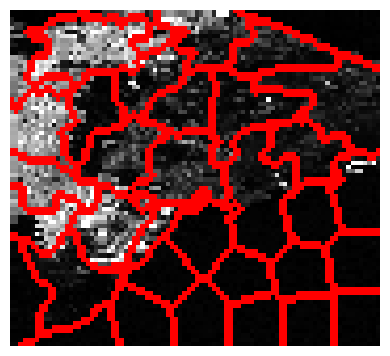

In [69]:
fig, axs = plt.subplots(1, 1, figsize = (4, 4))

ax = axs
# ax.imshow(mark_boundaries(hsi_dset_pro[:, :, find_index(1400, hsi_wavelegths)]/np.max(hsi_dset_pro[:, :, find_index(1400, hsi_wavelegths)]),
#                            hsi_slic, 
#                            color = (1, 0, 0)))
ax.imshow(mark_boundaries(1.3*libs_dset[:, :, find_index(610.22, libs_wavelegths)]/np.max(libs_dset[:, :, find_index(610.22, libs_wavelegths)]),
                           hsi_slic, 
                           color = (1, 0, 0), mode = 'outer')[::-1, ::-1])

ax.axis('off')
fig.tight_layout()
# fig.savefig("Images/SLIC_pattern_LIBS.jpg", dpi = 300)
# axs.scatter(centers[:, 1], centers[:, 0], c = 'y')

## 2.1 Fill each bounded region with the respective LIBS spectrum

In [70]:
libs_slic_upsample = upsample_to_slic(libs_dset_downsample, hsi_slic)
hsi_slic_upsample = upsample_to_slic(hsi_dset_downsample, hsi_slic)

100%|██████████| 35/35 [00:00<00:00, 782.13it/s]


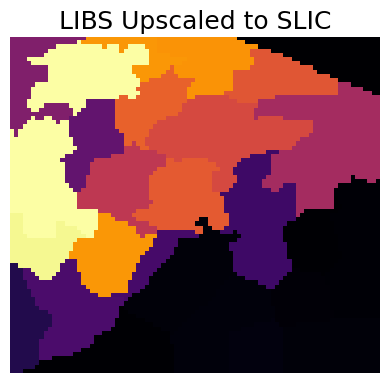

In [124]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (4, 4))

ax.imshow(libs_slic_upsample[:, :, find_index(670.76, libs_wavelegths)][::-1, ::-1], cmap = 'inferno')
ax.set_title("LIBS Upscaled to SLIC", fontsize = 18)
ax.axis("off")

fig.tight_layout()
# fig.savefig("Images/libs_slic_upscaled_inferno.jpg", dpi = 300)

# 3. Classification

In [72]:
lines = [288.167, 251.590, 252.817, 610.223, 670.764, 812.562, 769.811, 766.398, 693.80,
         568.766, 588.950, 819.400, 309.250, 308.169, 237.227, 779.939, 794.575]

# Apply gaussian filter and extract features
libs_flat = manual_features(libs_slic_upsample, lines, libs_wavelegths, sigma = None)
libs_flat = libs_flat.reshape(libs_flat.shape[0], -1).T

# Apply gaussian filter to the HSI dataset
hsi_flat = gaussian_filter(hsi_dset_pro, axes = (0, 1), sigma = 0.5).reshape(-1, spectral_size_hsi + end_band)
hsi_flat_slic = gaussian_filter(hsi_slic_upsample, axes = (0, 1), sigma = 0.5).reshape(-1, spectral_size_hsi + end_band)

## 3.1 Feature Extraction

In [74]:
### HSI ###
hsi_scaler = preprocessing.MinMaxScaler()
# hsi_scaled = hsi_scaler.fit_transform(hsi_flat)
hsi_scaled = hsi_flat

n_comps = 5
pca = PCA(n_components = n_comps) # 4 to 6 components explain 99.8% of variance
hsi_features = pca.fit_transform(hsi_scaled)
hsi_slic_features = pca.fit_transform(hsi_flat_slic)

In [75]:
np.cumsum(pca.explained_variance_ratio_)

array([0.91467619, 0.9816693 , 0.99209703, 0.99593982, 0.99782709])

In [76]:
### LIBS ###
lines = [288.167, 251.590, 252.817, 610.223, 670.764, 812.562, 769.811, 766.398, 693.80,
         568.766, 588.950, 819.400, 309.250, 308.169, 237.227, 779.939, 794.575]

libs_scaler = preprocessing.MinMaxScaler()
libs_scaled = libs_scaler.fit_transform(libs_flat)
libs_features = libs_scaled

## 3.2 Mid- Level Fusion

The features extracted for hyperspectral imaging (principal components extracted from PCA) and the ones for LIBS (manual selection of emission lines) are now combined in what is referred to as mid-level fusion. Th resulting dataset is then ready to be used for classification using K-Means clustering

In [98]:
l_w = 2
h_w = 1

ls_w = 2
hs_w = 1

mid_fusion = np.concatenate([h_w*hsi_features, l_w*libs_features], axis = 1)
mid_fusion_slics = np.concatenate([hs_w*hsi_slic_features, ls_w*libs_features], axis = 1)

mid_fusion.shape

(7040, 22)

## 3.3 Perform Classification using KMeans

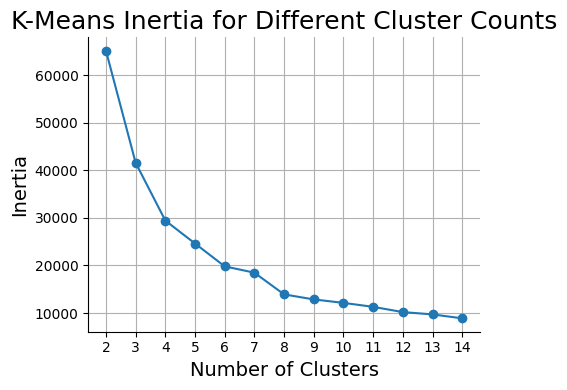

In [99]:
%matplotlib inline
cluster_range = np.arange(2, 15)
plot_kmeans_inertia(mid_fusion, cluster_range)

In [100]:
n_clusters = 5
classifier = KMeans(n_clusters = n_clusters, random_state = 10)
mid_fusion_labels = classifier.fit_predict(mid_fusion)
mid_fusion_labels = mid_fusion_labels.reshape(x_size, y_size)

mid_fusion_slic_labels = classifier.fit_predict(mid_fusion_slics)
mid_fusion_slic_labels = mid_fusion_slic_labels.reshape(x_size, y_size)

hsi_labels = classifier.fit_predict(hsi_features)
hsi_labels = hsi_labels.reshape(x_size, y_size)

## 3.4 Visualize

Notice some improvement in the lepidolite classification on the left of the image. On close inspection, mica classification also improved


In [101]:
hsi_order = [2, 4, 3, 0, 1]
collaborative_order = [2, 4, 3, 0, 1]

colors = ['xkcd:dark mauve', 'xkcd:pale', 'xkcd:light grey', 'xkcd:greenish grey', 'xkcd:white']
minerals = [r'Lepidolite [$KLi_2AlSi_4O_{10}F(OH)$]', 
            r'Albite [$NaAlSi_3O_8$]',
            r'Quartz [$SiO_2$]',
            r'Mica [$KAl_2(AlSi_3O_{10})(OH)_2$]',
            r'Background']

cmp_collaborative = ListedColormap([colors[i] for i in collaborative_order])
cmp_hsi = ListedColormap([colors[i] for i in hsi_order])

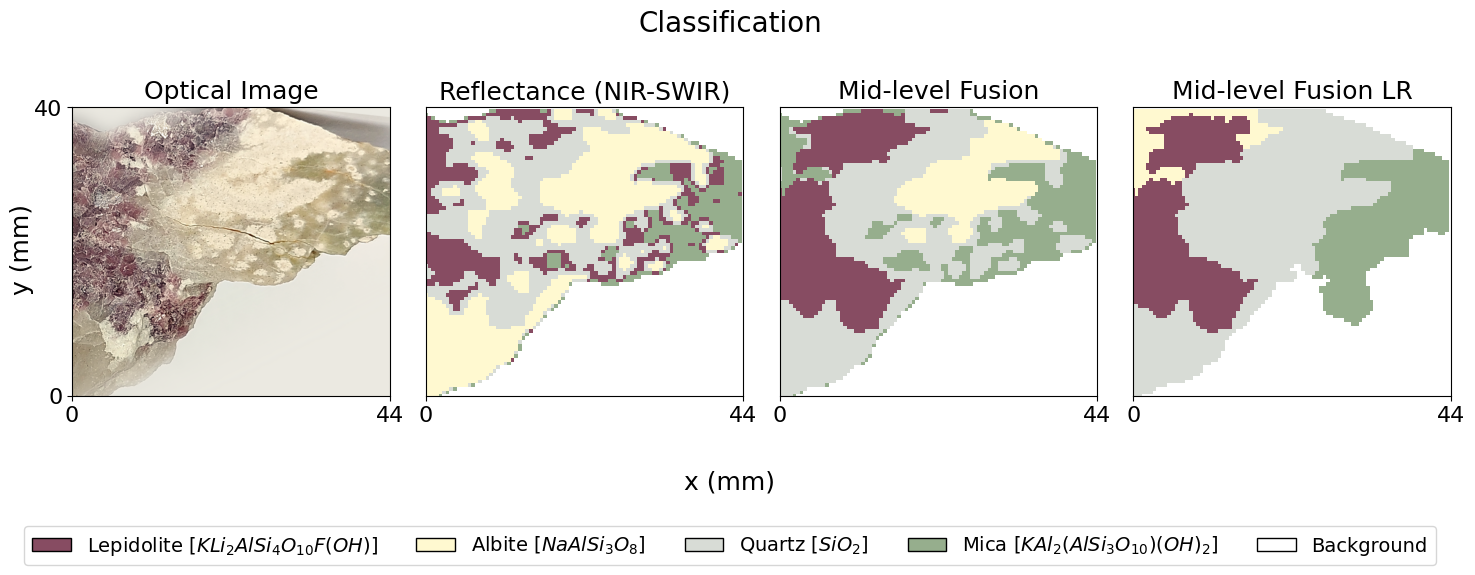

In [108]:
fig, axs = plt.subplots(1, 4, figsize = (15, 5))

fig.suptitle("Classification", fontsize = 20)

ax = axs[0]
ax.imshow(np.array(io.imread("Images/image_bife.png"))[400:1650, 200:1600][::, ::-1], 
          origin = 'lower', 
          extent = (0, y_size, 0, x_size))
ax.set_title("Optical Image", fontsize = 18)
ax.set_xticks([0, y_size])
ax.set_xticklabels([0, y_size//2], fontsize = 16)
ax.set_yticks([0, x_size])
ax.set_yticklabels([0, x_size//2], fontsize = 16)
ax.set_xlim(0, y_size)
ax.set_ylim(0, x_size)

ax = axs[2]
ax.imshow(mid_fusion_labels[::, ::-1], cmap = cmp_collaborative)
ax.set_title("Mid-level Fusion", fontsize = 18)
ax.set_xticks([0, y_size])
ax.set_xticklabels([0, y_size//2], fontsize = 16)
ax.set_yticks([ ])
ax.set_xlim(0, y_size)
ax.set_ylim(0, x_size)


ax = axs[1]
ax.imshow(hsi_labels[::, ::-1], cmap = cmp_hsi)
ax.set_title("Reflectance (NIR-SWIR)", fontsize = 18)
ax.set_xticks([0, y_size])
ax.set_xticklabels([0, y_size//2], fontsize = 16)
ax.set_yticks([ ])
ax.set_xlim(0, y_size)
ax.set_ylim(0, x_size)

ax = axs[3]
ax.imshow(mid_fusion_slic_labels[::, ::-1], cmap = cmp_hsi)
ax.set_title("Mid-level Fusion LR", fontsize = 18)
ax.set_xticks([0, y_size])
ax.set_xticklabels([0, y_size//2], fontsize = 16)
ax.set_yticks([ ])
ax.set_xlim(0, y_size)
ax.set_ylim(0, x_size)

handles = []

hls = []
for color,mineral in zip(colors,minerals):
    patch = mpatches.Patch(color = color, label = mineral, ec = 'k')
    hls.append(patch)

fig.supxlabel("x (mm)", fontsize = 18)
fig.supylabel("y (mm)", fontsize = 18)
fig.legend(handles = hls, loc = 'lower center', ncol = 5, fontsize = 14, bbox_to_anchor = (0.5, -0.15))
fig.tight_layout()
# fig.savefig("Images/Classification_results_w_optical_LR.jpg", dpi = 300)


# Notes:

In this notebook we opted to use the HSI data corrected with white and dark references, with no additional processing being done. This is in opposition to our prior approach where we applied hull_correction, savistky_golay filter, and threhold for low intensity (regions of spectrum lower than 0.1 are set to 0).

<span style="color:orange">On further inspection we noticed the removal of the spectral curvature in HSI - Hull Correction - significantly impacts the classification performance of the dataset</span>.

MovieWriter imagemagick unavailable; using Pillow instead.


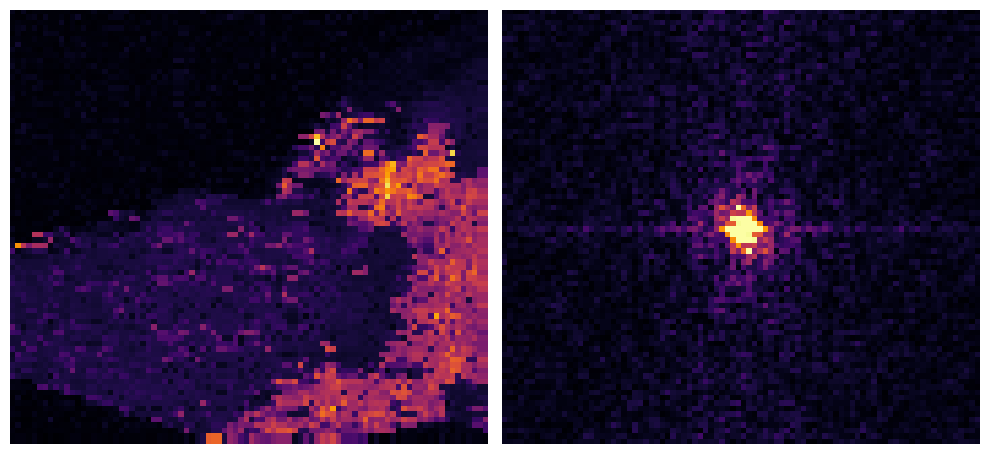

In [338]:
"""

Não relevante para este projeto

"""

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.fft import fft2, fftshift
# from matplotlib.colors import LogNorm
# import matplotlib.animation as animation

# def plot_images_and_ffts(dataset):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
#     ax1.axis('off')
#     ax2.axis('off')
#     plt.tight_layout()
    
#     initial_image = dataset[0]

#     fft_initial_image = fftshift(fft2(initial_image))
#     im1 = ax1.imshow(initial_image, cmap='inferno')
#     im2 = ax2.imshow(np.abs(fft_initial_image), vmax = np.max(np.abs(fft_initial_image))/10, cmap='inferno')

#     def update(index):
#         new_image = dataset[index % len(dataset)]
#         fft_new_image = fftshift(fft2(new_image))
        
#         im1.set_data(new_image)
#         im2.set_data(np.abs(fft_new_image))
#         im2.set_clim(vmax = np.max(np.abs(fft_new_image))/10)
#         im1.set_clim(vmax = np.max(new_image), vmin = np.min(new_image))

#         return [im1, im2]

#     ani = animation.FuncAnimation(fig, update, frames=len(dataset), interval=500, blit=True, repeat=True)

#     ani.save(r'C:/Users/tomas/Desktop/FFT_images/image_fft_animation_rock.gif', writer = 'imagemagick')

# plot_images_and_ffts(libs_flat)